In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm
import time
from joblib import Memory, Parallel, delayed
from scipy import stats
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# Create a memory cache to store the computation results
cachedir = './levy_cache'
memory = Memory(cachedir, verbose=0)

# Cache the levy_stable.fit function which is the bottleneck
@memory.cache
def cached_levy_fit(data):
    return levy_stable.fit(data)

# Download less data (5 years)
data = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')
log_returns = np.log(data['Close']).diff().dropna()

/tmp/ipykernel_30631/1418567111.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [5]:
# More aggressive downsampling
# You can adjust this value based on your accuracy requirements
downsample_factor = 1  # Use every 5th data point
log_returns = log_returns.iloc[::downsample_factor]

start_time = time.time()

# Use cached fit or parallel processing with initial parameter hints
# Providing decent initial parameter hints can significantly speed up convergence
initial_guess = [1.7, 0.0, 0.0, 0.01]  # Typical values for financial returns
alpha, beta, loc, scale = cached_levy_fit(log_returns.values)

fit_time = time.time() - start_time
print(f"Fitting took {fit_time:.2f} seconds")
print(f"Fitted parameters: alpha={alpha:.4f}, beta={beta:.4f}, loc={loc:.6f}, scale={scale:.6f}")
print(f"In standard notation: α={alpha:.4f}, β={beta:.4f}, γ={scale:.6f} (scale), δ={loc:.6f} (location)")

# Fit Gaussian (this is fast)
mu, sigma = log_returns.mean(), log_returns.std()

# Convert Series to scalar values (fixing the FutureWarning)
mu_scalar = float(mu.iloc[0]) if hasattr(mu, 'iloc') else float(mu)
sigma_scalar = float(sigma.iloc[0]) if hasattr(sigma, 'iloc') else float(sigma)

Fitting took 209.59 seconds
Fitted parameters: alpha=1.6247, beta=-0.2370, loc=0.000274, scale=0.006595
In standard notation: α=1.6247, β=-0.2370, γ=0.006595 (scale), δ=0.000274 (location)


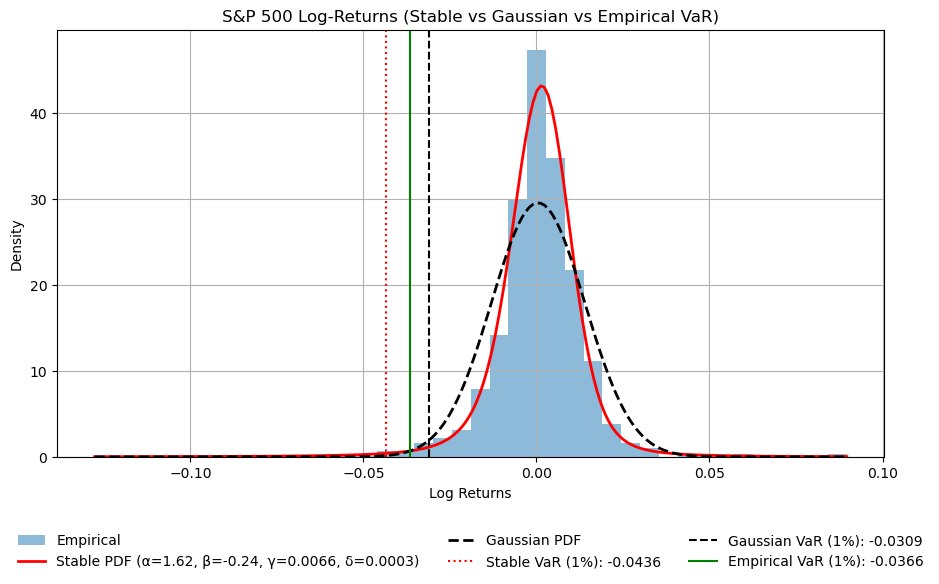

Stable VaR (1%): -0.043579
Gaussian VaR (1%): -0.030942
Empirical VaR (1%): -0.036597
Difference (Stable - Gaussian): -0.012636
Difference (Stable - Empirical): -0.006982
Difference (Gaussian - Empirical): 0.005655


In [6]:
# Calculate VaR levels
var_level = 0.01  # 1% VaR

# Compute model-based VaR (Value at Risk)
var_stable = levy_stable.ppf(var_level, alpha, beta, loc=loc, scale=scale)
var_gaussian = mu_scalar + norm.ppf(var_level) * sigma_scalar

# Compute empirical VaR
empirical_var = np.percentile(log_returns, var_level * 100)

# Plot with reduced number of points for the PDF calculation
x = np.linspace(log_returns.min(), log_returns.max(), 200)  # Fewer points for speed
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=40, density=True, alpha=0.5, label='Empirical')

# Use vectorized operations for faster PDF calculation
stable_pdf = levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale)
gauss_pdf = norm.pdf(x, loc=mu_scalar, scale=sigma_scalar)

plt.plot(x, stable_pdf, 'r-', lw=2, label=f'Stable PDF (α={alpha:.2f}, β={beta:.2f}, γ={scale:.4f}, δ={loc:.4f})')
plt.plot(x, gauss_pdf, 'k--', lw=2, label='Gaussian PDF')

plt.axvline(var_stable, color='r', linestyle=':', label=f'Stable VaR (1%): {var_stable:.4f}')
plt.axvline(var_gaussian, color='k', linestyle='--', label=f'Gaussian VaR (1%): {var_gaussian:.4f}')
plt.axvline(empirical_var, color='g', linestyle='-', label=f'Empirical VaR (1%): {empirical_var:.4f}')

plt.title('S&P 500 Log-Returns (Stable vs Gaussian vs Empirical VaR)')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.grid(True)
plt.tight_layout()
plt.savefig('sp500_var_analysis.png', dpi=300, transparent=True)
plt.show()

print(f"Stable VaR (1%): {var_stable:.6f}")
print(f"Gaussian VaR (1%): {var_gaussian:.6f}")
print(f"Empirical VaR (1%): {empirical_var:.6f}")
print(f"Difference (Stable - Gaussian): {(var_stable - var_gaussian):.6f}")
print(f"Difference (Stable - Empirical): {(var_stable - empirical_var):.6f}")
print(f"Difference (Gaussian - Empirical): {(var_gaussian - empirical_var):.6f}")

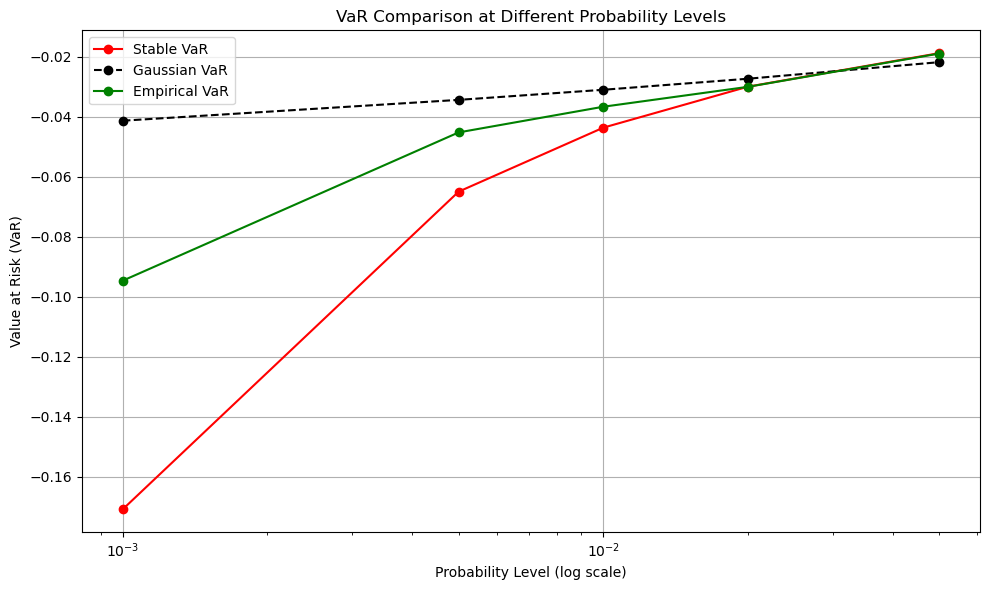


VaR Backtesting (1% level):
Stable Model: {'Expected Exceedances': 12.56, 'Actual Exceedances': 10, 'Ratio': 0.7961783439490445, 'Exceedance Rate': 0.007961783439490446}
Gaussian Model: {'Expected Exceedances': 12.56, 'Actual Exceedances': 23, 'Ratio': 1.8312101910828025, 'Exceedance Rate': 0.018312101910828025}

Expected Shortfall / Conditional VaR (1% level):
Empirical ES: -0.059020
Gaussian ES: -0.035518
Stable ES: -0.111205


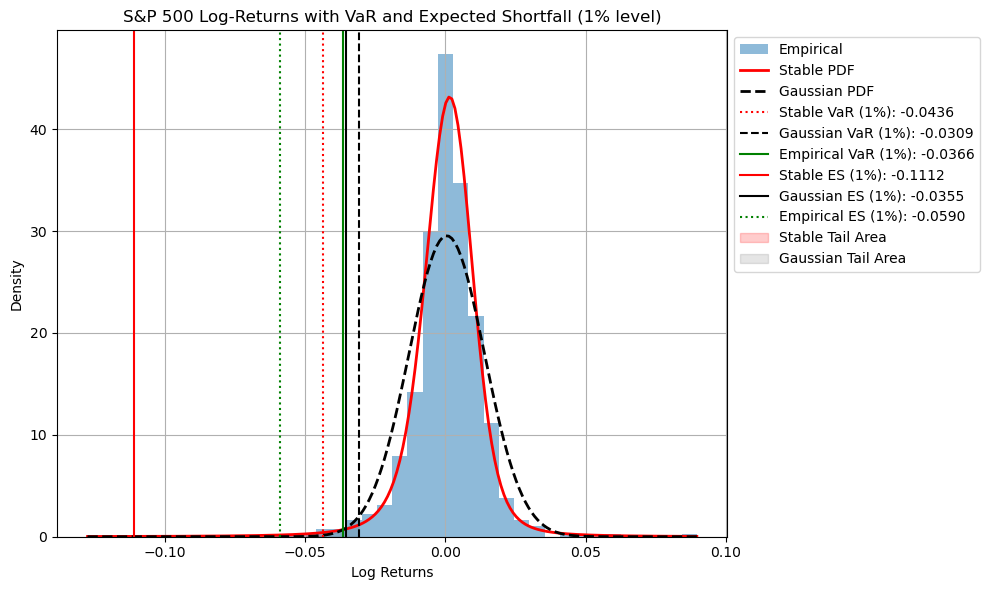

In [7]:
# Additional analysis: Calculate and plot different VaR levels
var_levels = np.array([0.001, 0.005, 0.01, 0.02, 0.05])

# Calculate VaR at different levels
empirical_vars = np.array([np.percentile(log_returns, level * 100) for level in var_levels])
stable_vars = np.array([levy_stable.ppf(level, alpha, beta, loc=loc, scale=scale) for level in var_levels])
gaussian_vars = np.array([mu_scalar + norm.ppf(level) * sigma_scalar for level in var_levels])

# Plot VaR comparison
plt.figure(figsize=(10, 6))
plt.plot(var_levels, stable_vars, 'ro-', label='Stable VaR')
plt.plot(var_levels, gaussian_vars, 'ko--', label='Gaussian VaR')
plt.plot(var_levels, empirical_vars, 'go-', label='Empirical VaR')
plt.xscale('log')
plt.xlabel('Probability Level (log scale)')
plt.ylabel('Value at Risk (VaR)')
plt.title('VaR Comparison at Different Probability Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('var_comparison.png', dpi=300, transparent=True)
plt.show()

# Create a backtesting function to check VaR accuracy
def backtest_var(returns, var_estimates, var_level):
    """Backtest VaR by counting exceedances"""
    # Ensure returns is a numpy array
    if hasattr(returns, 'values'):
        returns = returns.values

    exceedances = returns < var_estimates
    expected_exceedances = var_level * len(returns)
    actual_exceedances = np.sum(exceedances)
    return {
        'Expected Exceedances': expected_exceedances,
        'Actual Exceedances': actual_exceedances,
        'Ratio': actual_exceedances / expected_exceedances if expected_exceedances > 0 else np.nan,
        'Exceedance Rate': actual_exceedances / len(returns)
    }

# Check the performance of each model
var_level = 0.01  # 1% VaR
print("\nVaR Backtesting (1% level):")
print("Stable Model:", backtest_var(log_returns, var_stable, var_level))
print("Gaussian Model:", backtest_var(log_returns, var_gaussian, var_level))

# Calculate ES (Expected Shortfall) / CVaR (Conditional VaR)
# For empirical - ensure we're working with numpy arrays not Series
log_returns_values = log_returns.values if hasattr(log_returns, 'values') else log_returns
es_empirical = log_returns_values[log_returns_values <= empirical_var].mean()

# For Gaussian (analytical formula)
es_gaussian = mu_scalar - sigma_scalar * norm.pdf(norm.ppf(var_level)) / var_level

# For Stable (Monte Carlo approach due to lack of analytical formula)
# Generate samples from the fitted stable distribution
np.random.seed(42)  # For reproducibility
n_samples = 100000
stable_samples = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=n_samples)
es_stable = stable_samples[stable_samples <= var_stable].mean()

print("\nExpected Shortfall / Conditional VaR (1% level):")
print(f"Empirical ES: {es_empirical:.6f}")
print(f"Gaussian ES: {es_gaussian:.6f}")
print(f"Stable ES: {es_stable:.6f}")

# Visualize the Expected Shortfall
plt.figure(figsize=(10, 6))
plt.hist(log_returns, bins=40, density=True, alpha=0.5, label='Empirical')
plt.plot(x, stable_pdf, 'r-', lw=2, label='Stable PDF')
plt.plot(x, gauss_pdf, 'k--', lw=2, label='Gaussian PDF')

# Mark VaR points
plt.axvline(var_stable, color='r', linestyle=':', label=f'Stable VaR (1%): {var_stable:.4f}')
plt.axvline(var_gaussian, color='k', linestyle='--', label=f'Gaussian VaR (1%): {var_gaussian:.4f}')
plt.axvline(empirical_var, color='g', linestyle='-', label=f'Empirical VaR (1%): {empirical_var:.4f}')

# Mark ES points
plt.axvline(es_stable, color='r', linestyle='-', label=f'Stable ES (1%): {es_stable:.4f}')
plt.axvline(es_gaussian, color='k', linestyle='-', label=f'Gaussian ES (1%): {es_gaussian:.4f}')
plt.axvline(es_empirical, color='g', linestyle=':', label=f'Empirical ES (1%): {es_empirical:.4f}')

# Shade the tail areas - ensure we're working with 1D arrays
min_value = log_returns.min().iloc[0] if hasattr(log_returns.min(), 'iloc') else float(log_returns.min())
var_stable_value = var_stable.iloc[0] if hasattr(var_stable, 'iloc') else float(var_stable)
var_gaussian_value = var_gaussian.iloc[0] if hasattr(var_gaussian, 'iloc') else float(var_gaussian)

left_x = np.linspace(min_value, var_stable_value, 50)

# Ensure pdf calculation returns 1D array
y_stable = levy_stable.pdf(left_x, alpha, beta, loc=loc, scale=scale)
plt.fill_between(left_x, 0, y_stable, color='r', alpha=0.2, label='Stable Tail Area')

left_x_gauss = np.linspace(min_value, var_gaussian_value, 50)
y_gauss = norm.pdf(left_x_gauss, loc=mu_scalar, scale=sigma_scalar)
plt.fill_between(left_x_gauss, 0, y_gauss, color='k', alpha=0.1, label='Gaussian Tail Area')

plt.title('S&P 500 Log-Returns with VaR and Expected Shortfall (1% level)')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('var_es_comparison.png', dpi=300, transparent=True)
plt.show()